In [1]:
############################# needed for creating strategy
import os
import sys
sys.path.append("agent/util")
from simulation import BridgeAgent
from strategy import Strategy,StrategyActionSolver,MainSubStrategy,RandomMixStrategy

############################# needed for evaluating a strategy
import pprint
import itertools

from tqdm.notebook import tqdm

from simulation import Simulator,FixedActionSolver,exportJsonForVisualization,logger as simulation_logger
from visualizer import displayRoadNetStatistics

############################# log level setting
import logging
logging.basicConfig(level=logging.ERROR)
simulation_logger.setLevel(logging.INFO)

#############################
sys.path.append("agent")
from CBEngine_round3 import CBEngine_round3 as CBEngine_rllib_class

class SimulatorRunner:
    def __init__(self,
            simulator_cfg_file,
            metric_period,
            exportAgentLog=False,
            earlyStoppingDelayIndex=1.6,
        ):
        sim=Simulator(CBEngine_rllib_class,simulator_cfg_file,metric_period)

        print("****** simulator_configs ******")
        pprint.pprint(sim.simulator_configs)
        print("****** roadNet summary ******")
        sim.roadNet.printSummary()
        print("****** roadNet statistics ******")
        displayRoadNetStatistics(sim.roadNet)
        
        self.sim=sim
        self.exportAgentLogPath=sim.simulator_configs['report_log_addr']+"agent.txt" if exportAgentLog else None
        self.earlyStoppingDelayIndex=earlyStoppingDelayIndex
        
        self.total_served_vehicles_dic={}
        self.delay_index_dic={}
        self.lastTime_dic={}

    def runActionSolver(self,
            actionSolver,
            exportActionLogPath=None,
            recordKey=None
        ):
        print("****** evaluation ******")
        total_served_vehicles,delay_index,lastTime=self.sim.evaluate(
            BridgeAgent(actionSolver),
            earlyStoppingDelayIndex=self.earlyStoppingDelayIndex,
            tqdm=tqdm
        )
        if recordKey is not None:
            self.total_served_vehicles_dic[recordKey]=total_served_vehicles
            self.delay_index_dic[recordKey]=delay_index
            self.lastTime_dic[recordKey]=lastTime
        
        if exportActionLogPath is not None:
            actionSolver.exportActionLog(exportActionLogPath)
            print("action log exported:",exportActionLogPath)
            
    def runStrategy(self,
            strategy,
            actionTestCount,
            exportActionLogPath=None,
            recordKey=None
        ):
        actionSolver = StrategyActionSolver(
            strategy,
            export_agent_log_path=self.exportAgentLogPath,
            action_test_count=actionTestCount
        )
        self.runActionSolver(actionSolver,exportActionLogPath,recordKey)
            
    def printAllEvalRecord(self):
        print("****** all evaluation record ******")
        pprint.pprint(self.total_served_vehicles_dic)
        pprint.pprint(self.delay_index_dic)
        pprint.pprint(self.lastTime_dic)
        

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


****** simulator_configs ******
{'max_time_epoch': 1200,
 'report_log_addr': '/starter-kit/log/0/',
 'report_log_mode': 'normal',
 'report_log_rate': 10,
 'road_file_addr': '/starter-kit/data/roadnet_round3.txt',
 'start_time_epoch': 0,
 'vehicle_file_addr': '/starter-kit/data/flow_round3_flow0.txt',
 'warning_stop_time_log': 100}
****** roadNet summary ******
RoadDataSet has 3041 RoadSegmant, 6082 Road.
IntersectionDataSet has 2067 Intersection, 1004 Signal.
****** roadNet statistics ******
histgram of RoadSegment


<Figure size 432x288 with 0 Axes>

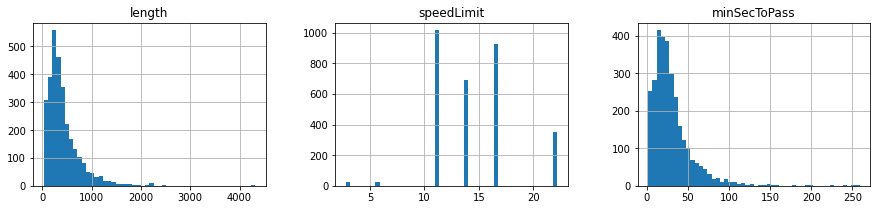

RoadSegment stat


11.111111    1015
16.666667     925
13.888889     694
22.222222     351
5.555556       28
2.777778       28
Name: speedLimit, dtype: int64

Road stat


[1, 0, 0, 0, 1, 0, 0, 0, 1]    6082
Name: permissibleMovementList, dtype: int64

Intersection stat


3    964
4    592
2    311
1    200
Name: numRoadSegment, dtype: int64

Signal stat


4    507
3    497
Name: numRoadSegment, dtype: int64

saved model signature ConcreteFunction signature_wrapper(*, inputs)
  Args:
    inputs: float32 Tensor, shape=(None, 597)
  Returns:
    {'output_0': <1>, 'output_1': <2>, 'output_2': <3>, 'output_3': <4>}
      <1>: float32 Tensor, shape=(None, 4, 8, 64)
      <2>: float32 Tensor, shape=(None, 4, 8, 64)
      <3>: float32 Tensor, shape=(None, 8, 1)
      <4>: float32 Tensor, shape=(None, 8, 1)
****** evaluation ******


0it [00:00, ?it/s]

INFO:simulation_util.py:****************************************
INFO:simulation_util.py:start to simulate
INFO:simulation_util.py:total evaluation cost 654.6295552253723 s


-----result----
last time : 1199
num served vehicles : 74926
delay index : 1.6037231105992107
---------------


INFO:simulation_util.py:****************************************
INFO:simulation_util.py:Evaluation complete


action log exported: action_log/round2_18_18_5_r1_dnn0_rule1_1.json


In [2]:
##################################### 混合strategyのテストを実行します
###parameters for simulator
simulator_cfg_file = "cfg/simulator_round3_flow0.cfg"
metric_period = 200
earlyStoppingDelayIndex=1.6

###parameters for DNN agent
dnnCheckpointFileName="round2_18_18_5_r1.ckpt"
dnnNumSegmentInbound=18
dnnNumSegmentOutbound=18
dimVehiclesVec=64
unitsDict={
    'inbound':[64,64,64,64],
}

###parameters for rule base agent
#maxDepth=4####
timeThresForCalcReward=10.2
prohibitDecreasingGoalDistance=True
prohibitDecreasingSpeed=True
depth=1####

###parameters for mixing strategy 
dnnStrategyRatio=0
ruleStrategyRatio=1

###parameters for actionSolver
actionTestCount=1
exportAgentLog=True

###parameters for visualization
exportForVisualization=False

#####################################
runner=SimulatorRunner(
    simulator_cfg_file,
    metric_period,
    exportAgentLog,
    earlyStoppingDelayIndex,
)

# dnnStrategy=Strategy.createStrategy(
#     'dnn_run_distance',{
#         'checkpointPath':"ckpt/"+dnnCheckpointFileName,
#         'numSegmentInbound':dnnNumSegmentInbound,
#         'numSegmentOutbound':dnnNumSegmentOutbound,
#         'unitsDict':unitsDict,
#         'dimVehiclesVec':dimVehiclesVec,
#     }
# )
dnnStrategy=Strategy.createStrategy(
    'dnn_saved_run_distance',{
        'savedModelPath':"saved_model/"+os.path.splitext(dnnCheckpointFileName)[0],
        'numSegmentInbound':dnnNumSegmentInbound,
        'numSegmentOutbound':dnnNumSegmentOutbound,
    }
)

ruleStrategy=Strategy.createStrategy(
    'run_distance',{
        #'maxDepth':maxDepth,####
        'timeThresForCalcReward':timeThresForCalcReward,
        'prohibitDecreasingGoalDistance':prohibitDecreasingGoalDistance,
        'prohibitDecreasingSpeed':prohibitDecreasingSpeed,
        'depth':depth####
    }
)

if dnnStrategyRatio is None or dnnStrategyRatio==0:
    strategy=ruleStrategy
elif ruleStrategyRatio is None or ruleStrategyRatio==0:
    strategy=dnnStrategy
else:
    strategy=RandomMixStrategy({
        dnnStrategy:dnnStrategyRatio/2,
        ruleStrategy:ruleStrategyRatio,
    })
    
runner.runStrategy(
    strategy,
    actionTestCount,
    exportActionLogPath = "action_log/{}_dnn{}_rule{}_{}.json".format(
        dnnCheckpointFileName.split(".")[0],
        dnnStrategyRatio,
        ruleStrategyRatio,
        actionTestCount,
    )
)

if exportForVisualization:
    print("now exporting simulation output as json for visualization")
    exportJsonForVisualization(simulator_cfg_file,every_n=10,tqdm=tqdm)

In [3]:
# routeを使用してるのでROUND3では動かない！！！！！！！

# ##################################### rule base strategyのテストを実行します（パラメータ探索機能付き）
# ###parameters for simulator
# simulator_cfg_file = "cfg/simulator_round2.cfg"
# metric_period = 200
# earlyStoppingDelayIndex=1.6

# ###parameters for rule base agent
# maxDepth_list=[4]
# timeThresForCalcReward_list=[10.2]
# prohibitDecreasingGoalDistance=True
# prohibitDecreasingSpeed=True

# ###parameters for actionSolver
# actionTestCount_list=[1]
# exportAgentLog=True

# ###parameters for visualization
# exportForVisualization=False

# #####################################
# runner=SimulatorRunner(
#     simulator_cfg_file,
#     metric_period,
#     exportAgentLog,
#     earlyStoppingDelayIndex,
# )

# params_list=list(itertools.product(
#     maxDepth_list,
#     timeThresForCalcReward_list,
#     actionTestCount_list,
# ))

# for params in params_list:
#     print(params)
#     strategy=Strategy.createStrategy(
#         'run_distance',
#         {
#             'maxDepth':params[0],
#             'timeThresForCalcReward':params[1],
#             'prohibitDecreasingGoalDistance':prohibitDecreasingGoalDistance,
#             'prohibitDecreasingSpeed':prohibitDecreasingSpeed,
#         }
#     )
#     runner.runStrategy(strategy,params[2],recordKey=params)

# runner.printAllEvalRecord()    

# if exportForVisualization:
#     print("now exporting simulation output as json for visualization")
#     exportJsonForVisualization(simulator_cfg_file,every_n=10,tqdm=tqdm)

In [4]:
# #####################################
# ###parameters for simulator
# metric_period = 1
# simulator_cfg_file = "cfg/simulator_test2.cfg"

# ###parameters for agent
# timeToActionsDict={
#     0:{
#         0:5,
#         1:7,
#     },
#     30:{
#         0:6,
#         1:8,
#     },
#     40:{
#         0:8,
#         1:8,
#     },
#     70:{
#         0:4,
#         1:6,
#     },
#     90:{
#         1:8,
#     },
# }
# #####################################
# runner=SimulatorRunner(
#     simulator_cfg_file,
#     metric_period,
# )

# runner.runActionSolver(FixedActionSolver(timeToActionsDict))

# exportJsonForVisualization(simulator_cfg_file,tqdm=tqdm)